In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
drive.mount('/content/drive')
# Load the dataset
data = pd.read_csv('/content/drive/My Drive//teleCust1000t.csv')

# Inspect the first few rows
print(data.head())

Mounted at /content/drive
   region  tenure  age  marital  address  income  ed  employ  retire  gender  \
0       2      13   44        1        9    64.0   4       5     0.0       0   
1       3      11   33        1        7   136.0   5       5     0.0       0   
2       3      68   52        1       24   116.0   1      29     0.0       1   
3       2      33   33        0       12    33.0   2       0     0.0       1   
4       2      23   30        1        9    30.0   1       2     0.0       0   

   reside  custcat  
0       2        1  
1       6        4  
2       2        3  
3       1        1  
4       4        3  


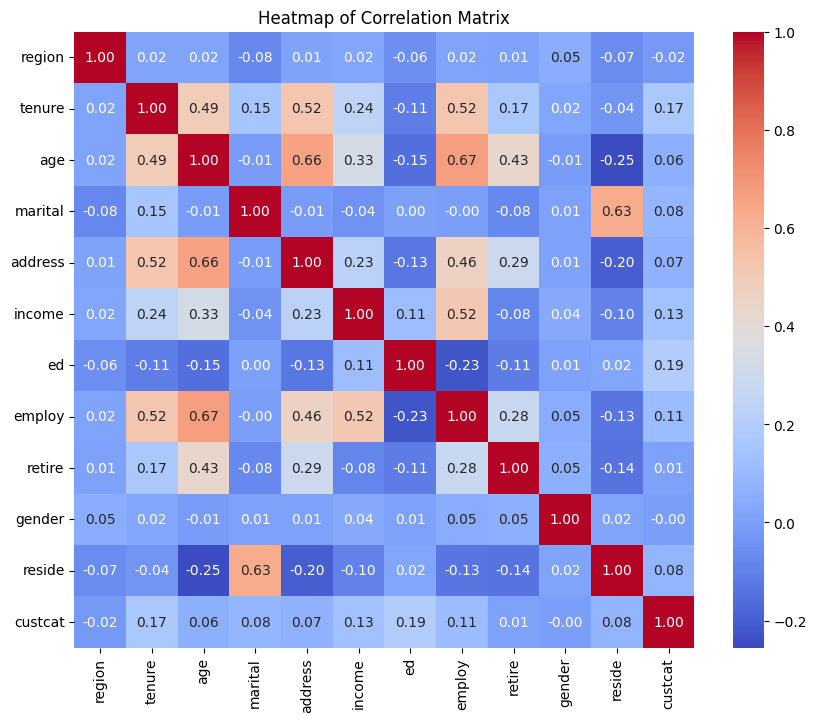

In [3]:
correlation_matrix = data.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")

plt.title("Heatmap of Correlation Matrix")
plt.show()

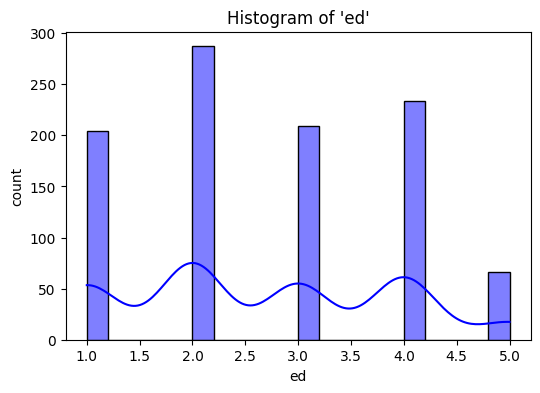

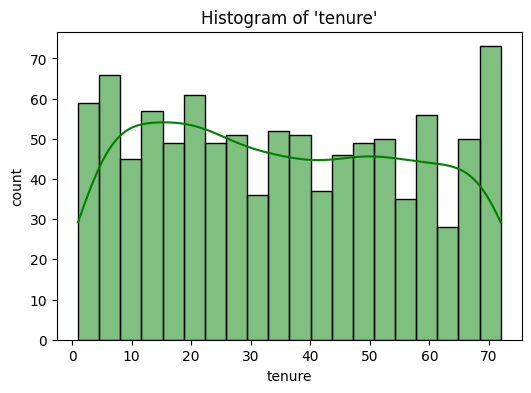

In [4]:
plt.figure(figsize=(6, 4))
sns.histplot(data['ed'], kde=True, bins=20, color='blue')
plt.title("Histogram of 'ed'")
plt.xlabel("ed")
plt.ylabel("count")
plt.show()


plt.figure(figsize=(6, 4))
sns.histplot(data['tenure'], kde=True, bins=20, color='green')
plt.title("Histogram of 'tenure'")
plt.xlabel("tenure")
plt.ylabel("count")
plt.show()

In [5]:
# 3. نرمال‌سازی داده‌ها با استفاده از MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 4. تبدیل داده‌های نرمال‌شده به DataFrame
scaled_data_df = pd.DataFrame(scaled_data, columns=data.columns)

# 5. تقسیم داده‌ها به ویژگی‌ها (X) و فیلد هدف (y)
X = scaled_data_df
y = data['custcat']  # فرض بر این است که 'custcat' فیلد هدف است

# 6. تقسیم داده‌ها به train، validation و test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=33)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=33)

# چاپ اندازه‌های مجموعه‌ها
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 700 samples
Validation set: 150 samples
Test set: 150 samples


In [6]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

from tensorflow.keras.utils import to_categorical


# تبدیل برچسب‌ها به One-Hot Encoding
y_train = to_categorical(y_train-1, num_classes=4)
y_val = to_categorical(y_val-1, num_classes=4)
y_test = to_categorical(y_test-1, num_classes=4)




# Define a function to create an MLP model with optional BatchNormalization and Dropout
def create_model(layers=1, neurons=32, optimizer='sgd', use_batchnorm=False, dropout_rate=0.0):
    model = Sequential()

    # Input layer and first hidden layer
    model.add(Dense(neurons, activation='relu', input_shape=(X_train.shape[1],)))
    if use_batchnorm:
        model.add(BatchNormalization())
    if dropout_rate > 0.0:
        model.add(Dropout(dropout_rate))

    # Additional hidden layer if layers=2
    if layers == 2:
        model.add(Dense(neurons, activation='relu'))
        if use_batchnorm:
            model.add(BatchNormalization())
        if dropout_rate > 0.0:
            model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(4, activation='softmax'))


    # Compile the model with SGD optimizer
    if optimizer == 'sgd':
        opt = SGD(learning_rate=0.01)  # Using SGD optimizer
    else:
        raise ValueError("Unsupported optimizer")

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])  # Use categorical_crossentropy for multi-class
    return model

# آزمایش با تعداد نورون‌های مختلف
neurons_list = [16, 32, 64]  # تعداد نورون‌های مختلف برای بررسی
results = []

for neurons in neurons_list:
    print(f"\nTraining model with {neurons} neurons...")

    model1 = create_model(layers=1, neurons=neurons, use_batchnorm=True, dropout_rate=0.0, optimizer='sgd')
    model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)

    model2 = create_model(layers=2, neurons=neurons, use_batchnorm=True, dropout_rate=0.0, optimizer='sgd')
    model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)

    # ارزیابی مدل بر روی داده‌های تست
    loss_1, accuracy_1 = model1.evaluate(X_test, y_test, verbose=0)
    print(f"Accuracy for model1 with {neurons} neurons: {accuracy_1:.4f}")

    loss_2, accuracy_2 = model2.evaluate(X_test, y_test, verbose=0)
    print(f"Accuracy for model2 with {neurons} neurons: {accuracy_2:.4f}")

    results.append({
        "Neurons": neurons,
        "Model 1 Accuracy": accuracy_1,
        "Model 2 Accuracy": accuracy_2
    })


# نمایش نتایج مقایسه
print("\nComparison of results:")
for result in results:
    print(f"Model with {result['Neurons']} neurons - Accuracy: {result['Model 1 Accuracy']:.4f}, Model 2 Accuracy: {result['Model 2 Accuracy']:.4f}")


Training model with 16 neurons...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1660 - loss: 1.7316 - val_accuracy: 0.1933 - val_loss: 1.3861
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2788 - loss: 1.5004 - val_accuracy: 0.3000 - val_loss: 1.3613
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4708 - loss: 1.2554 - val_accuracy: 0.2867 - val_loss: 1.3363
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5586 - loss: 1.1079 - val_accuracy: 0.3667 - val_loss: 1.3061
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6183 - loss: 1.0161 - val_accuracy: 0.4133 - val_loss: 1.2718
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6555 - loss: 0.9721 - val_accuracy: 0.4800 - val_loss: 1.2317
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6879 - loss: 0.8901 - val_accuracy: 0.5600 - val_loss: 1.1851
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7019 - loss: 0.8381 - val_accuracy: 0.6067 - val_loss

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2916 - loss: 1.6810 - val_accuracy: 0.2733 - val_loss: 1.4165
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4116 - loss: 1.3348 - val_accuracy: 0.2067 - val_loss: 1.3823
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5326 - loss: 1.1482 - val_accuracy: 0.1867 - val_loss: 1.3738
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6072 - loss: 1.0020 - val_accuracy: 0.2467 - val_loss: 1.3550
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6507 - loss: 0.9172 - val_accuracy: 0.3400 - val_loss: 1.3264
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6561 - loss: 0.8503 - val_accuracy: 0.4333 - val_loss: 1.2834
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6748 - loss: 0.8022 - val_accuracy: 0.5267 - val_loss: 1.2247
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6742 - loss: 0.8011 - val_accuracy: 0.5467 - val_loss: 1.1767
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3552 - loss: 1.6323 - val_accuracy: 0.4267 - val_loss: 1.3258
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5320 - loss: 1.0421 - val_accuracy: 0.5000 - val_loss: 1.2826
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6863 - loss: 0.8715 - val_accuracy: 0.5200 - val_loss: 1.2350
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7469 - loss: 0.7428 - val_accuracy: 0.6000 - val_loss: 1.1863
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7892 - loss: 0.6799 - val_accuracy: 0.6933 - val_loss: 1.1365
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8451 - loss: 0.5997 - val_accuracy: 0.7667 - val_loss: 1.0830
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8158 - loss: 0.5913 - val_accuracy: 0.8133 - val_loss: 1.0293
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8532 - loss: 0.5253 - val_accuracy: 0.8467 - val_loss: 0.9729
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3735 - loss: 1.5162 - val_accuracy: 0.2333 - val_loss: 1.3874
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5186 - loss: 1.1672 - val_accuracy: 0.3200 - val_loss: 1.3448
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6362 - loss: 0.9055 - val_accuracy: 0.3600 - val_loss: 1.3041
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6781 - loss: 0.8115 - val_accuracy: 0.3800 - val_loss: 1.2592
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7445 - loss: 0.6931 - val_accuracy: 0.3933 - val_loss: 1.2071
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8084 - loss: 0.6187 - val_accuracy: 0.4133 - val_loss: 1.1402
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8265 - loss: 0.5433 - val_accuracy: 0.4733 - val_loss: 1.0576
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8604 - loss: 0.4619 - val_accuracy: 0.5667 - val_loss: 0.9690
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3186 - loss: 1.4929 - val_accuracy: 0.3000 - val_loss: 1.3554
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5577 - loss: 1.0750 - val_accuracy: 0.3933 - val_loss: 1.3051
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6636 - loss: 0.8127 - val_accuracy: 0.4533 - val_loss: 1.2558
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7287 - loss: 0.7297 - val_accuracy: 0.5667 - val_loss: 1.2076
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7597 - loss: 0.6395 - val_accuracy: 0.6067 - val_loss: 1.1587
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7921 - loss: 0.5790 - val_accuracy: 0.6267 - val_loss: 1.1093
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8144 - loss: 0.5295 - val_accuracy: 0.6800 - val_loss: 1.0577
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8187 - loss: 0.5403 - val_accuracy: 0.7400 - val_loss: 1.0073
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4637 - loss: 1.2068 - val_accuracy: 0.2600 - val_loss: 1.3318
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7223 - loss: 0.7520 - val_accuracy: 0.3333 - val_loss: 1.2770
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7519 - loss: 0.6293 - val_accuracy: 0.4600 - val_loss: 1.2151
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8182 - loss: 0.4838 - val_accuracy: 0.4933 - val_loss: 1.1534
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8635 - loss: 0.4436 - val_accuracy: 0.5000 - val_loss: 1.0910
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8747 - loss: 0.3949 - val_accuracy: 0.4867 - val_loss: 1.0308
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8874 - loss: 0.3550 - val_accuracy: 0.5400 - val_loss: 0.9621
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9073 - loss: 0.3113 - val_accuracy: 0.5733 - val_loss: 0.8989
Ep

In [7]:

dropout_rates = [0.0, 0.3]

use_batchnorm_options = [True, False]  # Add both options for BatchNormalization


results = []  # To store results for comparison

for dropout_rate in dropout_rates:
    for use_batchnorm in use_batchnorm_options:
        batchnorm_text = "with BatchNormalization" if use_batchnorm else "without BatchNormalization"
        dropout_text = "with Dropout" if dropout_rate > 0.0 else "without Dropout"

        print(f"\nTraining Model 1: 1 hidden layer, 64 neurons, {batchnorm_text} and {dropout_text} (Dropout rate {dropout_rate})...")
        model_1 = create_model(layers=1, neurons=64, use_batchnorm=use_batchnorm, dropout_rate=dropout_rate)
        model_1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)

        print(f"\nTraining Model 2: 2 hidden layers, 64 neurons, {batchnorm_text} and {dropout_text} (Dropout rate {dropout_rate})...")
        model_2 = create_model(layers=2, neurons=64, use_batchnorm=use_batchnorm, dropout_rate=dropout_rate)
        model_2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)

        # Evaluate Model 1
        print(f"\nEvaluating Model 1 on test set {batchnorm_text} and {dropout_text}...")
        loss_1, accuracy_1 = model_1.evaluate(X_test, y_test, verbose=0)
        print(f"Model 1 Accuracy: {accuracy_1:.4f}")

        # Evaluate Model 2
        print(f"\nEvaluating Model 2 on test set {batchnorm_text} and {dropout_text}...")
        loss_2, accuracy_2 = model_2.evaluate(X_test, y_test, verbose=0)
        print(f"Model 2 Accuracy: {accuracy_2:.4f}")

        # Store the results for comparison
        results.append({
            "Model 1 Accuracy": accuracy_1,
            "Model 2 Accuracy": accuracy_2,
            "Dropout Rate": dropout_rate,
            "BatchNorm": batchnorm_text
        })

# Print comparison results
print("\nComparison of Results:")
for result in results:
    print(f"Dropout Rate: {result['Dropout Rate']}, BatchNorm: {result['BatchNorm']}, Model 1 Accuracy: {result['Model 1 Accuracy']:.4f}, Model 2 Accuracy: {result['Model 2 Accuracy']:.4f}")



Training Model 1: 1 hidden layer, 64 neurons, with BatchNormalization and without Dropout (Dropout rate 0.0)...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2424 - loss: 1.7414 - val_accuracy: 0.3733 - val_loss: 1.3406
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5164 - loss: 1.1474 - val_accuracy: 0.5467 - val_loss: 1.2978
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6600 - loss: 0.9365 - val_accuracy: 0.5867 - val_loss: 1.2531
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7089 - loss: 0.7954 - val_accuracy: 0.6467 - val_loss: 1.2071
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7324 - loss: 0.7454 - val_accuracy: 0.7333 - val_loss: 1.1589
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7225 - loss: 0.6888 - val_accuracy: 0.7533 - val_loss: 1.1065
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7788 - loss: 0.6102 - val_accuracy: 0.7867 - val_loss: 1.0550
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8009 - loss: 0.5870 - val_accuracy: 0.8133 - val_loss: 1.0015
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4008 - loss: 1.4581 - val_accuracy: 0.1800 - val_loss: 1.3550
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7383 - loss: 0.7280 - val_accuracy: 0.2800 - val_loss: 1.2961
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8130 - loss: 0.5716 - val_accuracy: 0.4467 - val_loss: 1.2302
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8486 - loss: 0.4482 - val_accuracy: 0.5600 - val_loss: 1.1667
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8905 - loss: 0.4212 - val_accuracy: 0.6067 - val_loss: 1.1014
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8885 - loss: 0.3644 - val_accuracy: 0.6200 - val_loss: 1.0369
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9531 - loss: 0.2892 - val_accuracy: 0.6200 - val_loss: 0.9682
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9458 - loss: 0.2629 - val_accuracy: 0.6400 - val_loss: 0.8999
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2588 - loss: 1.4195 - val_accuracy: 0.3000 - val_loss: 1.3704
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2811 - loss: 1.4076 - val_accuracy: 0.3267 - val_loss: 1.3665
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3037 - loss: 1.3853 - val_accuracy: 0.3200 - val_loss: 1.3626
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2938 - loss: 1.3769 - val_accuracy: 0.3400 - val_loss: 1.3584
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3211 - loss: 1.3676 - val_accuracy: 0.3533 - val_loss: 1.3543
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3669 - loss: 1.3448 - val_accuracy: 0.3800 - val_loss: 1.3496
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3646 - loss: 1.3449 - val_accuracy: 0.3867 - val_loss: 1.3447
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4008 - loss: 1.3282 - val_accuracy: 0.4000 - val_loss: 1.3394
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3455 - loss: 1.3570 - val_accuracy: 0.3867 - val_loss: 1.3488
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4783 - loss: 1.3376 - val_accuracy: 0.4467 - val_loss: 1.3428
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5328 - loss: 1.3153 - val_accuracy: 0.4200 - val_loss: 1.3354
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5425 - loss: 1.2952 - val_accuracy: 0.4200 - val_loss: 1.3259
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5439 - loss: 1.2811 - val_accuracy: 0.4467 - val_loss: 1.3155
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5780 - loss: 1.2479 - val_accuracy: 0.4533 - val_loss: 1.3012
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6011 - loss: 1.2322 - val_accuracy: 0.4600 - val_loss: 1.2857
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5654 - loss: 1.2289 - val_accuracy: 0.4600 - val_loss: 1.2681
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2367 - loss: 2.0335 - val_accuracy: 0.3133 - val_loss: 1.3262
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4300 - loss: 1.2412 - val_accuracy: 0.3533 - val_loss: 1.2874
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6043 - loss: 0.9217 - val_accuracy: 0.4600 - val_loss: 1.2456
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6442 - loss: 0.8164 - val_accuracy: 0.4733 - val_loss: 1.1944
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6842 - loss: 0.7243 - val_accuracy: 0.5133 - val_loss: 1.1417
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7065 - loss: 0.6903 - val_accuracy: 0.6600 - val_loss: 1.0843
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6857 - loss: 0.7100 - val_accuracy: 0.7600 - val_loss: 1.0261
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7390 - loss: 0.6361 - val_accuracy: 0.7933 - val_loss: 0.9693
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2847 - loss: 1.9622 - val_accuracy: 0.1600 - val_loss: 1.3825
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4609 - loss: 1.2490 - val_accuracy: 0.2000 - val_loss: 1.3143
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5878 - loss: 0.9775 - val_accuracy: 0.3000 - val_loss: 1.2560
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6035 - loss: 0.9012 - val_accuracy: 0.5200 - val_loss: 1.1936
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6934 - loss: 0.7831 - val_accuracy: 0.6067 - val_loss: 1.1288
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7041 - loss: 0.7166 - val_accuracy: 0.6600 - val_loss: 1.0600
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6726 - loss: 0.7605 - val_accuracy: 0.6933 - val_loss: 0.9713
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7557 - loss: 0.6127 - val_accuracy: 0.7200 - val_loss: 0.8993
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2002 - loss: 1.6158 - val_accuracy: 0.2400 - val_loss: 1.4387
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1974 - loss: 1.5150 - val_accuracy: 0.2133 - val_loss: 1.4195
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2271 - loss: 1.4479 - val_accuracy: 0.2133 - val_loss: 1.4093
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2198 - loss: 1.4280 - val_accuracy: 0.2133 - val_loss: 1.4027
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2848 - loss: 1.3937 - val_accuracy: 0.2400 - val_loss: 1.3987
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3080 - loss: 1.3859 - val_accuracy: 0.3133 - val_loss: 1.3947
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3009 - loss: 1.3860 - val_accuracy: 0.3200 - val_loss: 1.3905
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3318 - loss: 1.3630 - val_accuracy: 0.3067 - val_loss: 1.3861
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2431 - loss: 1.4041 - val_accuracy: 0.2733 - val_loss: 1.4044
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3064 - loss: 1.3866 - val_accuracy: 0.3400 - val_loss: 1.3971
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2480 - loss: 1.3958 - val_accuracy: 0.3667 - val_loss: 1.3910
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2526 - loss: 1.3912 - val_accuracy: 0.3667 - val_loss: 1.3853
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3177 - loss: 1.3572 - val_accuracy: 0.3667 - val_loss: 1.3807
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3108 - loss: 1.3670 - val_accuracy: 0.3667 - val_loss: 1.3753
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3656 - loss: 1.3467 - val_accuracy: 0.3733 - val_loss: 1.3692
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3745 - loss: 1.3468 - val_accuracy: 0.3800 - val_loss: 1.3632
Ep

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop

# Function to create a model without L2-Regularization
def create_model(layers=1, neurons=32, optimizer='adam', use_batchnorm=False, dropout_rate=0.0):
    model = Sequential()

    # Input layer and first hidden layer without L2-Regularization
    model.add(Dense(neurons, activation='relu', input_shape=(X_train.shape[1],)))
    if use_batchnorm:
        model.add(BatchNormalization())
    if dropout_rate > 0.0:
        model.add(Dropout(dropout_rate))

    # Additional hidden layer if layers=2
    if layers == 2:
        model.add(Dense(neurons, activation='relu'))  # No L2 Regularization
        if use_batchnorm:
            model.add(BatchNormalization())
        if dropout_rate > 0.0:
            model.add(Dropout(dropout_rate))

    # Output layer for multiclass classification
    model.add(Dense(4, activation='sigmoid'))  # 4 output neurons for 4 classes

    # Compile the model
    if optimizer == 'adam':
        opt = Adam(learning_rate=0.001)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=0.001)
    else:
        raise ValueError("Unsupported optimizer")

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameters to evaluate
dropout_rates = [0.0, 0.3]
use_batchnorm_options = [True, False]  # Both options for BatchNormalization

results = []  # To store results for comparison

# Train and evaluate models with both Adam and RMSprop optimizers
for optimizer in ['adam', 'rmsprop']:
    for dropout_rate in dropout_rates:
        for use_batchnorm in use_batchnorm_options:
            batchnorm_text = "with BatchNormalization" if use_batchnorm else "without BatchNormalization"
            dropout_text = "with Dropout" if dropout_rate > 0.0 else "without Dropout"

            print(f"\nTraining Model 1: 1 hidden layer, 64 neurons, {batchnorm_text} and {dropout_text} (Dropout rate {dropout_rate}) with {optimizer} optimizer...")
            model_1 = create_model(layers=1, neurons=64, use_batchnorm=use_batchnorm, dropout_rate=dropout_rate, optimizer=optimizer)
            model_1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)

            print(f"\nTraining Model 2: 2 hidden layers, 64 neurons, {batchnorm_text} and {dropout_text} (Dropout rate {dropout_rate}) with {optimizer} optimizer...")
            model_2 = create_model(layers=2, neurons=64, use_batchnorm=use_batchnorm, dropout_rate=dropout_rate, optimizer=optimizer)
            model_2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)

            # Evaluate Model 1
            print(f"\nEvaluating Model 1 on test set {batchnorm_text} and {dropout_text} with {optimizer} optimizer...")
            loss_1, accuracy_1 = model_1.evaluate(X_test, y_test, verbose=0)
            print(f"Model 1 Accuracy: {accuracy_1:.4f}")

            # Evaluate Model 2
            print(f"\nEvaluating Model 2 on test set {batchnorm_text} and {dropout_text} with {optimizer} optimizer...")
            loss_2, accuracy_2 = model_2.evaluate(X_test, y_test, verbose=0)
            print(f"Model 2 Accuracy: {accuracy_2:.4f}")

            # Store the results for comparison
            results.append({
                "Model 1 Accuracy": accuracy_1,
                "Model 2 Accuracy": accuracy_2,
                "Dropout Rate": dropout_rate,
                "BatchNorm": batchnorm_text,
                "Optimizer": optimizer
            })

# Print comparison results
print("\nComparison of Results:")
for result in results:
    print(f"Optimizer: {result['Optimizer']}, Dropout Rate: {result['Dropout Rate']}, BatchNorm: {result['BatchNorm']}, Model 1 Accuracy: {result['Model 1 Accuracy']:.4f}, Model 2 Accuracy: {result['Model 2 Accuracy']:.4f}")



Training Model 1: 1 hidden layer, 64 neurons, with BatchNormalization and without Dropout (Dropout rate 0.0) with adam optimizer...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3188 - loss: 1.6893 - val_accuracy: 0.2067 - val_loss: 1.3930
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4774 - loss: 1.1772 - val_accuracy: 0.2333 - val_loss: 1.3445
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6737 - loss: 0.8546 - val_accuracy: 0.2867 - val_loss: 1.2960
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7391 - loss: 0.6926 - val_accuracy: 0.3333 - val_loss: 1.2467
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8021 - loss: 0.6064 - val_accuracy: 0.4467 - val_loss: 1.1870
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8166 - loss: 0.5485 - val_accuracy: 0.5333 - val_loss: 1.1199
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8293 - loss: 0.4955 - val_accuracy: 0.5733 - val_loss: 1.0519
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8713 - loss: 0.4072 - val_accuracy: 0.6133 - val_loss: 0.9866
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4310 - loss: 1.3940 - val_accuracy: 0.3533 - val_loss: 1.3285
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7368 - loss: 0.7321 - val_accuracy: 0.3333 - val_loss: 1.2855
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8277 - loss: 0.4978 - val_accuracy: 0.4067 - val_loss: 1.2270
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8733 - loss: 0.4366 - val_accuracy: 0.5600 - val_loss: 1.1550
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8845 - loss: 0.3500 - val_accuracy: 0.6667 - val_loss: 1.0727
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9114 - loss: 0.2939 - val_accuracy: 0.7600 - val_loss: 0.9823
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9338 - loss: 0.2359 - val_accuracy: 0.8133 - val_loss: 0.8916
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9593 - loss: 0.2067 - val_accuracy: 0.7933 - val_loss: 0.8288
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2845 - loss: 1.3723 - val_accuracy: 0.2867 - val_loss: 1.3633
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4076 - loss: 1.2921 - val_accuracy: 0.2800 - val_loss: 1.3251
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4318 - loss: 1.2591 - val_accuracy: 0.4133 - val_loss: 1.2733
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5321 - loss: 1.1814 - val_accuracy: 0.4467 - val_loss: 1.2221
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6173 - loss: 1.0986 - val_accuracy: 0.5067 - val_loss: 1.1634
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6734 - loss: 1.0489 - val_accuracy: 0.5733 - val_loss: 1.1007
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6818 - loss: 1.0031 - val_accuracy: 0.6267 - val_loss: 1.0427
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6988 - loss: 0.9301 - val_accuracy: 0.6400 - val_loss

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3025 - loss: 1.3696 - val_accuracy: 0.3267 - val_loss: 1.3326
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4943 - loss: 1.2457 - val_accuracy: 0.5400 - val_loss: 1.2161
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6345 - loss: 1.1238 - val_accuracy: 0.5533 - val_loss: 1.0573
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6751 - loss: 0.9255 - val_accuracy: 0.6733 - val_loss: 0.8555
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7979 - loss: 0.7131 - val_accuracy: 0.8133 - val_loss: 0.6651
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8373 - loss: 0.5848 - val_accuracy: 0.8733 - val_loss: 0.5283
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9025 - loss: 0.4482 - val_accuracy: 0.9133 - val_loss: 0.4258
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9195 - loss: 0.3631 - val_accuracy: 0.9267 - val_loss: 0.3545
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2456 - loss: 1.9030 - val_accuracy: 0.2800 - val_loss: 1.3772
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3863 - loss: 1.4815 - val_accuracy: 0.3933 - val_loss: 1.3401
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4914 - loss: 1.1793 - val_accuracy: 0.4267 - val_loss: 1.3036
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5570 - loss: 1.0183 - val_accuracy: 0.5133 - val_loss: 1.2540
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6330 - loss: 0.8931 - val_accuracy: 0.5400 - val_loss: 1.2039
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6552 - loss: 0.8236 - val_accuracy: 0.6000 - val_loss: 1.1440
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6767 - loss: 0.7410 - val_accuracy: 0.6800 - val_loss: 1.0758
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7316 - loss: 0.7024 - val_accuracy: 0.7067 - val_loss: 1.0170
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.2778 - loss: 1.9379 - val_accuracy: 0.2067 - val_loss: 1.3534
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4873 - loss: 1.2270 - val_accuracy: 0.3333 - val_loss: 1.2980
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6419 - loss: 0.8484 - val_accuracy: 0.3333 - val_loss: 1.2430
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6387 - loss: 0.8452 - val_accuracy: 0.3000 - val_loss: 1.1949
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7517 - loss: 0.6203 - val_accuracy: 0.2800 - val_loss: 1.1461
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7597 - loss: 0.5807 - val_accuracy: 0.3067 - val_loss: 1.0941
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7903 - loss: 0.5239 - val_accuracy: 0.3667 - val_loss: 1.0313
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7821 - loss: 0.5162 - val_accuracy: 0.4200 - val_loss: 0.9642
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2803 - loss: 1.3936 - val_accuracy: 0.3533 - val_loss: 1.3419
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3895 - loss: 1.3346 - val_accuracy: 0.3933 - val_loss: 1.3196
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4615 - loss: 1.2590 - val_accuracy: 0.4733 - val_loss: 1.2907
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5208 - loss: 1.2337 - val_accuracy: 0.5067 - val_loss: 1.2476
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5599 - loss: 1.1661 - val_accuracy: 0.5133 - val_loss: 1.2036
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6117 - loss: 1.1162 - val_accuracy: 0.5467 - val_loss: 1.1549
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6034 - loss: 1.0749 - val_accuracy: 0.5800 - val_loss: 1.0996
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6418 - loss: 1.0474 - val_accuracy: 0.6000 - val_loss: 1.0549
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2938 - loss: 1.3986 - val_accuracy: 0.3933 - val_loss: 1.3463
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4434 - loss: 1.3079 - val_accuracy: 0.4800 - val_loss: 1.2945
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5007 - loss: 1.2349 - val_accuracy: 0.5267 - val_loss: 1.1949
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5336 - loss: 1.1435 - val_accuracy: 0.5867 - val_loss: 1.0569
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5754 - loss: 0.9958 - val_accuracy: 0.6667 - val_loss: 0.9005
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6575 - loss: 0.8646 - val_accuracy: 0.7933 - val_loss: 0.7560
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6894 - loss: 0.7344 - val_accuracy: 0.8000 - val_loss: 0.6411
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7186 - loss: 0.6668 - val_accuracy: 0.8733 - val_loss: 0.5484
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3770 - loss: 1.4404 - val_accuracy: 0.3467 - val_loss: 1.3433
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6357 - loss: 0.9531 - val_accuracy: 0.4067 - val_loss: 1.2875
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6729 - loss: 0.8016 - val_accuracy: 0.5067 - val_loss: 1.2288
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7499 - loss: 0.6632 - val_accuracy: 0.5467 - val_loss: 1.1709
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7888 - loss: 0.5802 - val_accuracy: 0.5733 - val_loss: 1.1073
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7923 - loss: 0.5619 - val_accuracy: 0.6200 - val_loss: 1.0475
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8215 - loss: 0.5079 - val_accuracy: 0.6267 - val_loss: 0.9860
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8514 - loss: 0.4338 - val_accuracy: 0.6533 - val_loss: 0.9273
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3618 - loss: 1.5595 - val_accuracy: 0.2867 - val_loss: 1.3253
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7467 - loss: 0.6712 - val_accuracy: 0.3533 - val_loss: 1.2683
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8474 - loss: 0.4609 - val_accuracy: 0.4667 - val_loss: 1.1992
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9030 - loss: 0.3466 - val_accuracy: 0.6000 - val_loss: 1.0971
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9271 - loss: 0.2834 - val_accuracy: 0.6200 - val_loss: 1.0139
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9359 - loss: 0.2413 - val_accuracy: 0.6733 - val_loss: 0.9097
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9640 - loss: 0.1986 - val_accuracy: 0.7067 - val_loss: 0.8184
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9444 - loss: 0.1783 - val_accuracy: 0.6933 - val_loss: 0.7545
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3637 - loss: 1.3658 - val_accuracy: 0.4733 - val_loss: 1.3289
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5026 - loss: 1.3032 - val_accuracy: 0.5533 - val_loss: 1.2917
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5810 - loss: 1.2490 - val_accuracy: 0.5600 - val_loss: 1.2477
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6021 - loss: 1.1973 - val_accuracy: 0.5467 - val_loss: 1.1968
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6185 - loss: 1.1281 - val_accuracy: 0.5600 - val_loss: 1.1359
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6465 - loss: 1.0618 - val_accuracy: 0.6000 - val_loss: 1.0729
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6625 - loss: 0.9929 - val_accuracy: 0.6267 - val_loss: 1.0141
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6711 - loss: 0.9397 - val_accuracy: 0.6400 - val_loss: 0.9551
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4351 - loss: 1.3358 - val_accuracy: 0.5267 - val_loss: 1.2684
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5941 - loss: 1.1510 - val_accuracy: 0.5400 - val_loss: 1.0926
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6497 - loss: 0.9730 - val_accuracy: 0.5400 - val_loss: 0.9234
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6862 - loss: 0.7952 - val_accuracy: 0.6467 - val_loss: 0.7628
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7830 - loss: 0.6470 - val_accuracy: 0.8067 - val_loss: 0.6293
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8797 - loss: 0.5305 - val_accuracy: 0.8333 - val_loss: 0.5361
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9099 - loss: 0.4564 - val_accuracy: 0.8933 - val_loss: 0.4505
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9350 - loss: 0.3887 - val_accuracy: 0.9133 - val_loss: 0.3619
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3171 - loss: 1.6636 - val_accuracy: 0.3800 - val_loss: 1.3534
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4495 - loss: 1.2249 - val_accuracy: 0.4333 - val_loss: 1.3133
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5195 - loss: 1.0491 - val_accuracy: 0.5067 - val_loss: 1.2695
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6090 - loss: 0.8977 - val_accuracy: 0.4933 - val_loss: 1.2130
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6549 - loss: 0.8276 - val_accuracy: 0.5933 - val_loss: 1.1576
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7171 - loss: 0.6911 - val_accuracy: 0.6067 - val_loss: 1.0988
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7524 - loss: 0.6093 - val_accuracy: 0.6467 - val_loss: 1.0397
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7307 - loss: 0.6256 - val_accuracy: 0.6667 - val_loss: 0.9737
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.2895 - loss: 2.0578 - val_accuracy: 0.3800 - val_loss: 1.3701
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4945 - loss: 1.2454 - val_accuracy: 0.3667 - val_loss: 1.3198
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6323 - loss: 0.9149 - val_accuracy: 0.3800 - val_loss: 1.2591
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6509 - loss: 0.7988 - val_accuracy: 0.3733 - val_loss: 1.1856
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7323 - loss: 0.6261 - val_accuracy: 0.3867 - val_loss: 1.0968
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7545 - loss: 0.5614 - val_accuracy: 0.3733 - val_loss: 1.0393
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7986 - loss: 0.5146 - val_accuracy: 0.3933 - val_loss: 0.9482
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7732 - loss: 0.5203 - val_accuracy: 0.4133 - val_loss: 0.8560
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3102 - loss: 1.3504 - val_accuracy: 0.4000 - val_loss: 1.3276
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4499 - loss: 1.2785 - val_accuracy: 0.4933 - val_loss: 1.2860
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5518 - loss: 1.2165 - val_accuracy: 0.5200 - val_loss: 1.2394
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5528 - loss: 1.1808 - val_accuracy: 0.5467 - val_loss: 1.1908
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5915 - loss: 1.1366 - val_accuracy: 0.5467 - val_loss: 1.1463
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6268 - loss: 1.0569 - val_accuracy: 0.6000 - val_loss: 1.0895
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6558 - loss: 1.0171 - val_accuracy: 0.6000 - val_loss: 1.0465
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6359 - loss: 0.9924 - val_accuracy: 0.6267 - val_loss: 0.9979
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3346 - loss: 1.3538 - val_accuracy: 0.4467 - val_loss: 1.2767
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5073 - loss: 1.2019 - val_accuracy: 0.5267 - val_loss: 1.1804
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5614 - loss: 1.0958 - val_accuracy: 0.5733 - val_loss: 1.0605
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6132 - loss: 1.0049 - val_accuracy: 0.6000 - val_loss: 0.9491
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6403 - loss: 0.9335 - val_accuracy: 0.6333 - val_loss: 0.8561
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6682 - loss: 0.8489 - val_accuracy: 0.6867 - val_loss: 0.7597
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6809 - loss: 0.7647 - val_accuracy: 0.7133 - val_loss: 0.6870
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7334 - loss: 0.7015 - val_accuracy: 0.8067 - val_loss: 0.6022
Ep

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2

# Function to create a model with or without L2-Regularization
def create_model(layers=1, neurons=32, optimizer='adam', use_batchnorm=False, dropout_rate=0.0, l2_reg=0.0001):
    model = Sequential()

    # Input layer and first hidden layer
    model.add(Dense(neurons, activation='relu',
                    input_shape=(X_train.shape[1],),
                    kernel_regularizer=l2(l2_reg)))
    if use_batchnorm:
        model.add(BatchNormalization())
    if dropout_rate > 0.0:
        model.add(Dropout(dropout_rate))

    # Additional hidden layer if layers=2
    if layers == 2:
        model.add(Dense(neurons, activation='relu',
                        kernel_regularizer=l2(l2_reg)))
        if use_batchnorm:
            model.add(BatchNormalization())
        if dropout_rate > 0.0:
            model.add(Dropout(dropout_rate))

    # Output layer for multiclass classification
    model.add(Dense(4, activation='softmax'))

    # Compile the model
    if optimizer == 'adam':
        opt = Adam(learning_rate=0.001)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=0.001)
    else:
        raise ValueError("Unsupported optimizer")

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameters to evaluate
dropout_rates = [0.0, 0.3]
use_batchnorm_options = [True, False]  # Both options for BatchNormalization

results = []  # To store results for comparison

# Train and evaluate models with L2-Regularization (0.0001) and different settings
for optimizer in ['adam', 'rmsprop']:
    for dropout_rate in dropout_rates:
        for use_batchnorm in use_batchnorm_options:
            batchnorm_text = "with BatchNormalization" if use_batchnorm else "without BatchNormalization"
            dropout_text = "with Dropout" if dropout_rate > 0.0 else "without Dropout"

            print(f"\nTraining Model 1: 1 hidden layer, 64 neurons, {batchnorm_text}, {dropout_text} (Dropout rate {dropout_rate}), L2=0.0001, {optimizer} optimizer...")
            model_1 = create_model(layers=1, neurons=64, use_batchnorm=use_batchnorm, dropout_rate=dropout_rate, optimizer=optimizer, l2_reg=0.0001)
            model_1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)

            print(f"\nTraining Model 2: 2 hidden layers, 64 neurons, {batchnorm_text}, {dropout_text} (Dropout rate {dropout_rate}), L2=0.0001, {optimizer} optimizer...")
            model_2 = create_model(layers=2, neurons=64, use_batchnorm=use_batchnorm, dropout_rate=dropout_rate, optimizer=optimizer, l2_reg=0.0001)
            model_2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)

            # Evaluate Model 1
            print(f"\nEvaluating Model 1 on test set {batchnorm_text}, {dropout_text}, L2=0.0001, {optimizer} optimizer...")
            loss_1, accuracy_1 = model_1.evaluate(X_test, y_test, verbose=0)
            print(f"Model 1 Accuracy: {accuracy_1:.4f}")

            # Evaluate Model 2
            print(f"\nEvaluating Model 2 on test set {batchnorm_text}, {dropout_text}, L2=0.0001, {optimizer} optimizer...")
            loss_2, accuracy_2 = model_2.evaluate(X_test, y_test, verbose=0)
            print(f"Model 2 Accuracy: {accuracy_2:.4f}")

            # Store the results for comparison
            results.append({
                "Model 1 Accuracy": accuracy_1,
                "Model 2 Accuracy": accuracy_2,
                "Dropout Rate": dropout_rate,
                "BatchNorm": batchnorm_text,
                "Optimizer": optimizer,
                "L2 Regularization": 0.0001
            })

# Print comparison results
print("\nComparison of Results:")
for result in results:
    print(f"Optimizer: {result['Optimizer']}, Dropout Rate: {result['Dropout Rate']}, BatchNorm: {result['BatchNorm']}, L2 Regularization: {result['L2 Regularization']}, Model 1 Accuracy: {result['Model 1 Accuracy']:.4f}, Model 2 Accuracy: {result['Model 2 Accuracy']:.4f}")



Training Model 1: 1 hidden layer, 64 neurons, with BatchNormalization, without Dropout (Dropout rate 0.0), L2=0.0001, adam optimizer...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2607 - loss: 1.7141 - val_accuracy: 0.3267 - val_loss: 1.3474
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5598 - loss: 1.0909 - val_accuracy: 0.3400 - val_loss: 1.3066
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6316 - loss: 0.8523 - val_accuracy: 0.3600 - val_loss: 1.2604
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7208 - loss: 0.7106 - val_accuracy: 0.4533 - val_loss: 1.2014
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7516 - loss: 0.6326 - val_accuracy: 0.5200 - val_loss: 1.1466
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8080 - loss: 0.5408 - val_accuracy: 0.5733 - val_loss: 1.0882
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8329 - loss: 0.4953 - val_accuracy: 0.6000 - val_loss: 1.0348
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8555 - loss: 0.4470 - val_accuracy: 0.6667 - val_loss: 0.9625
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.3983 - loss: 1.6151 - val_accuracy: 0.3000 - val_loss: 1.3377
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7211 - loss: 0.7267 - val_accuracy: 0.4467 - val_loss: 1.2606
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7986 - loss: 0.5510 - val_accuracy: 0.5467 - val_loss: 1.1861
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8576 - loss: 0.4355 - val_accuracy: 0.6667 - val_loss: 1.1031
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9276 - loss: 0.3089 - val_accuracy: 0.7733 - val_loss: 1.0014
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9378 - loss: 0.2818 - val_accuracy: 0.8200 - val_loss: 0.9166
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9691 - loss: 0.2073 - val_accuracy: 0.8333 - val_loss: 0.8146
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9757 - loss: 0.1760 - val_accuracy: 0.8600 - val_loss: 0.7288
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2298 - loss: 1.4417 - val_accuracy: 0.2067 - val_loss: 1.4218
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3149 - loss: 1.3810 - val_accuracy: 0.3200 - val_loss: 1.3857
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4855 - loss: 1.3215 - val_accuracy: 0.4200 - val_loss: 1.3349
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5780 - loss: 1.2541 - val_accuracy: 0.5000 - val_loss: 1.2801
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6279 - loss: 1.1795 - val_accuracy: 0.5533 - val_loss: 1.2088
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6878 - loss: 1.0939 - val_accuracy: 0.5733 - val_loss: 1.1382
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7021 - loss: 1.0030 - val_accuracy: 0.5533 - val_loss: 1.0743
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6997 - loss: 0.9482 - val_accuracy: 0.6000 - val_loss: 1.0015
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3292 - loss: 1.3598 - val_accuracy: 0.2933 - val_loss: 1.3449
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5107 - loss: 1.2514 - val_accuracy: 0.5267 - val_loss: 1.2399
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6663 - loss: 1.1181 - val_accuracy: 0.5600 - val_loss: 1.0916
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6568 - loss: 0.9543 - val_accuracy: 0.6667 - val_loss: 0.9011
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7624 - loss: 0.7761 - val_accuracy: 0.7467 - val_loss: 0.7404
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8094 - loss: 0.6183 - val_accuracy: 0.8333 - val_loss: 0.5923
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8528 - loss: 0.5265 - val_accuracy: 0.8733 - val_loss: 0.5033
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8895 - loss: 0.4252 - val_accuracy: 0.9133 - val_loss: 0.4225
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3041 - loss: 1.7617 - val_accuracy: 0.3933 - val_loss: 1.3477
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4522 - loss: 1.2538 - val_accuracy: 0.4933 - val_loss: 1.3008
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5707 - loss: 1.0532 - val_accuracy: 0.5467 - val_loss: 1.2530
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6505 - loss: 0.8518 - val_accuracy: 0.6267 - val_loss: 1.1996
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6919 - loss: 0.7330 - val_accuracy: 0.7000 - val_loss: 1.1455
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7413 - loss: 0.6680 - val_accuracy: 0.7267 - val_loss: 1.0937
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7296 - loss: 0.6076 - val_accuracy: 0.7200 - val_loss: 1.0394
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7975 - loss: 0.5585 - val_accuracy: 0.7200 - val_loss: 0.9841
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.3230 - loss: 1.7382 - val_accuracy: 0.5267 - val_loss: 1.3275
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5020 - loss: 1.1474 - val_accuracy: 0.5600 - val_loss: 1.2775
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6334 - loss: 0.9394 - val_accuracy: 0.6200 - val_loss: 1.2143
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6629 - loss: 0.8154 - val_accuracy: 0.7000 - val_loss: 1.1405
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7203 - loss: 0.7281 - val_accuracy: 0.7533 - val_loss: 1.0573
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7468 - loss: 0.6103 - val_accuracy: 0.7533 - val_loss: 0.9805
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7663 - loss: 0.5807 - val_accuracy: 0.7467 - val_loss: 0.9059
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7874 - loss: 0.4925 - val_accuracy: 0.8200 - val_loss: 0.7981
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3286 - loss: 1.3908 - val_accuracy: 0.3000 - val_loss: 1.3781
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4117 - loss: 1.3046 - val_accuracy: 0.3000 - val_loss: 1.3456
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4737 - loss: 1.2599 - val_accuracy: 0.3400 - val_loss: 1.2972
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4543 - loss: 1.2557 - val_accuracy: 0.4467 - val_loss: 1.2495
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5414 - loss: 1.1620 - val_accuracy: 0.4933 - val_loss: 1.1985
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6027 - loss: 1.0987 - val_accuracy: 0.5267 - val_loss: 1.1463
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6001 - loss: 1.0586 - val_accuracy: 0.5400 - val_loss: 1.0793
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6194 - loss: 0.9927 - val_accuracy: 0.5933 - val_loss: 1.0232
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2700 - loss: 1.3990 - val_accuracy: 0.3867 - val_loss: 1.3569
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4279 - loss: 1.3303 - val_accuracy: 0.5200 - val_loss: 1.3129
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5369 - loss: 1.2556 - val_accuracy: 0.5333 - val_loss: 1.2322
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5364 - loss: 1.1539 - val_accuracy: 0.5800 - val_loss: 1.0903
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6086 - loss: 1.0147 - val_accuracy: 0.6133 - val_loss: 0.9287
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6381 - loss: 0.8599 - val_accuracy: 0.6867 - val_loss: 0.7756
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7005 - loss: 0.7400 - val_accuracy: 0.7467 - val_loss: 0.6608
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7383 - loss: 0.6506 - val_accuracy: 0.8400 - val_loss: 0.5529
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2592 - loss: 1.7489 - val_accuracy: 0.3667 - val_loss: 1.3489
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5115 - loss: 1.1643 - val_accuracy: 0.4400 - val_loss: 1.2959
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6591 - loss: 0.9071 - val_accuracy: 0.4933 - val_loss: 1.2436
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7480 - loss: 0.7473 - val_accuracy: 0.5733 - val_loss: 1.1833
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7843 - loss: 0.6295 - val_accuracy: 0.6533 - val_loss: 1.1107
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8058 - loss: 0.5521 - val_accuracy: 0.6800 - val_loss: 1.0412
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8141 - loss: 0.5237 - val_accuracy: 0.7200 - val_loss: 0.9658
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8379 - loss: 0.4723 - val_accuracy: 0.7400 - val_loss: 0.9013
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4050 - loss: 1.4513 - val_accuracy: 0.3467 - val_loss: 1.3327
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7633 - loss: 0.7004 - val_accuracy: 0.3067 - val_loss: 1.2878
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7968 - loss: 0.5445 - val_accuracy: 0.3867 - val_loss: 1.2241
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8728 - loss: 0.4031 - val_accuracy: 0.4533 - val_loss: 1.1656
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9305 - loss: 0.2948 - val_accuracy: 0.5600 - val_loss: 1.0832
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9706 - loss: 0.2113 - val_accuracy: 0.5933 - val_loss: 0.9863
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9631 - loss: 0.1774 - val_accuracy: 0.6467 - val_loss: 0.8598
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9772 - loss: 0.1479 - val_accuracy: 0.6867 - val_loss: 0.7725
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2841 - loss: 1.3810 - val_accuracy: 0.3000 - val_loss: 1.3485
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4063 - loss: 1.2957 - val_accuracy: 0.3467 - val_loss: 1.3090
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5076 - loss: 1.2423 - val_accuracy: 0.4267 - val_loss: 1.2668
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5954 - loss: 1.1743 - val_accuracy: 0.5267 - val_loss: 1.2140
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6526 - loss: 1.1238 - val_accuracy: 0.5800 - val_loss: 1.1623
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6548 - loss: 1.0672 - val_accuracy: 0.5933 - val_loss: 1.1118
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6795 - loss: 1.0085 - val_accuracy: 0.6000 - val_loss: 1.0627
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6837 - loss: 0.9474 - val_accuracy: 0.6400 - val_loss: 1.0007
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4129 - loss: 1.3607 - val_accuracy: 0.5600 - val_loss: 1.2815
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5916 - loss: 1.1975 - val_accuracy: 0.5600 - val_loss: 1.1465
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6542 - loss: 1.0453 - val_accuracy: 0.5867 - val_loss: 1.0113
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6707 - loss: 0.9094 - val_accuracy: 0.6400 - val_loss: 0.8645
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7453 - loss: 0.7570 - val_accuracy: 0.7600 - val_loss: 0.7232
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8520 - loss: 0.6242 - val_accuracy: 0.7933 - val_loss: 0.6195
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8563 - loss: 0.5401 - val_accuracy: 0.9000 - val_loss: 0.5220
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8832 - loss: 0.4752 - val_accuracy: 0.9267 - val_loss: 0.4460
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3517 - loss: 1.6424 - val_accuracy: 0.3867 - val_loss: 1.3313
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5317 - loss: 1.1466 - val_accuracy: 0.4400 - val_loss: 1.2957
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6535 - loss: 0.8971 - val_accuracy: 0.4800 - val_loss: 1.2520
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6990 - loss: 0.7929 - val_accuracy: 0.5600 - val_loss: 1.1996
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7182 - loss: 0.7089 - val_accuracy: 0.6733 - val_loss: 1.1374
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7511 - loss: 0.6547 - val_accuracy: 0.7267 - val_loss: 1.0777
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7523 - loss: 0.6009 - val_accuracy: 0.7333 - val_loss: 1.0182
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7840 - loss: 0.5196 - val_accuracy: 0.7867 - val_loss: 0.9497
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.3444 - loss: 1.7656 - val_accuracy: 0.2533 - val_loss: 1.3614
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4853 - loss: 1.2383 - val_accuracy: 0.4000 - val_loss: 1.2889
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6406 - loss: 0.9190 - val_accuracy: 0.4200 - val_loss: 1.2236
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6856 - loss: 0.8011 - val_accuracy: 0.4200 - val_loss: 1.1343
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7498 - loss: 0.6312 - val_accuracy: 0.4600 - val_loss: 1.0487
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7438 - loss: 0.6274 - val_accuracy: 0.4733 - val_loss: 0.9644
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8199 - loss: 0.4766 - val_accuracy: 0.5000 - val_loss: 0.8853
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8432 - loss: 0.4064 - val_accuracy: 0.5667 - val_loss: 0.8051
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2168 - loss: 1.4030 - val_accuracy: 0.3067 - val_loss: 1.3641
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4172 - loss: 1.3181 - val_accuracy: 0.3400 - val_loss: 1.3284
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5080 - loss: 1.2569 - val_accuracy: 0.4200 - val_loss: 1.2894
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5470 - loss: 1.2219 - val_accuracy: 0.4533 - val_loss: 1.2512
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5784 - loss: 1.1737 - val_accuracy: 0.5000 - val_loss: 1.2008
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5895 - loss: 1.1094 - val_accuracy: 0.5733 - val_loss: 1.1452
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6280 - loss: 1.0596 - val_accuracy: 0.5800 - val_loss: 1.0964
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6606 - loss: 1.0164 - val_accuracy: 0.6133 - val_loss: 1.0465
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2778 - loss: 1.3894 - val_accuracy: 0.3133 - val_loss: 1.3239
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4080 - loss: 1.2734 - val_accuracy: 0.5600 - val_loss: 1.2592
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4746 - loss: 1.2150 - val_accuracy: 0.5667 - val_loss: 1.1577
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6179 - loss: 1.0789 - val_accuracy: 0.6000 - val_loss: 1.0525
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6505 - loss: 0.9878 - val_accuracy: 0.6800 - val_loss: 0.9341
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6958 - loss: 0.8741 - val_accuracy: 0.7067 - val_loss: 0.8343
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7305 - loss: 0.7747 - val_accuracy: 0.7667 - val_loss: 0.7256
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7642 - loss: 0.7063 - val_accuracy: 0.8200 - val_loss: 0.6462
Ep

In [15]:
import numpy as np
import pandas as pd

# انتخاب 10 نمونه به صورت تصادفی از داده‌های تست
random_indices = np.random.choice(X_test.shape[0], size=10, replace=False)
X_test_sample = X_test.iloc[random_indices]
y_test_sample = y_test[random_indices]

# پیش‌بینی و ارزیابی مدل‌ها برای 10 نمونه انتخاب شده
results = []

# تنظیمات مدل‌ها
model_configs = [
    {"optimizer": "adam", "dropout_rate": 0.0, "batchnorm": False, "l2": 0.0001},
    {"optimizer": "rmsprop", "dropout_rate": 0.0, "batchnorm": False, "l2": 0.0001},
]

for config in model_configs:
    optimizer = config["optimizer"]
    dropout_rate = config["dropout_rate"]
    use_batchnorm = config["batchnorm"]
    l2_reg = config["l2"]

    # ایجاد مدل با تنظیمات مشخص
    model = create_model(
        layers=2,
        neurons=64,
        optimizer=optimizer,
        use_batchnorm=use_batchnorm,
        dropout_rate=dropout_rate,
        l2_reg=l2_reg,
    )

    # آموزش مدل
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=0)

    # پیش‌بینی برای نمونه‌های تصادفی
    predictions = model.predict(X_test_sample)
    predicted_classes = np.argmax(predictions, axis=1)
    actual_classes = np.argmax(y_test_sample, axis=1)

    # نمایش نتایج برای هر نمونه
    print(f"\nModel: {optimizer} optimizer, Dropout Rate: {dropout_rate}, BatchNorm: {use_batchnorm}, L2 Regularization: {l2_reg}")
    print("-" * 60)
    for i in range(10):
        print(f"Sample {i + 1}:")
        print(f"  - Actual class: {actual_classes[i]}")
        print(f"  - Predicted class: {predicted_classes[i]}")
        print("-" * 40)

    # ارزیابی مدل روی داده‌های تست
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Model Accuracy on Test Data: {accuracy:.4f}")

    # ذخیره نتایج
    results.append({
        "Optimizer": optimizer,
        "Dropout Rate": dropout_rate,
        "BatchNorm": use_batchnorm,
        "L2 Regularization": l2_reg,
        "Accuracy": accuracy,
    })

# نمایش نتایج کلی مقایسه
print("\nComparison of Results:")
for result in results:
    print(
        f"Optimizer: {result['Optimizer']}, Dropout Rate: {result['Dropout Rate']}, "
        f"BatchNorm: {result['BatchNorm']}, L2 Regularization: {result['L2 Regularization']}, "
        f"Accuracy: {result['Accuracy']:.4f}"
    )


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

Model: adam optimizer, Dropout Rate: 0.0, BatchNorm: False, L2 Regularization: 0.0001
------------------------------------------------------------
Sample 1:
  - Actual class: 0
  - Predicted class: 0
----------------------------------------
Sample 2:
  - Actual class: 2
  - Predicted class: 2
----------------------------------------
Sample 3:
  - Actual class: 2
  - Predicted class: 2
----------------------------------------
Sample 4:
  - Actual class: 0
  - Predicted class: 0
----------------------------------------
Sample 5:
  - Actual class: 2
  - Predicted class: 2
----------------------------------------
Sample 6:
  - Actual class: 0
  - Predicted class: 0
----------------------------------------
Sample 7:
  - Actual class: 1
  - Predicted class: 1
----------------------------------------
Sample 8:
  - Actual class: 2
  - Predicted class: 2
----------------------------------------
Sample 9:
  - Actual class: 0
  - Predicted class: 0
---------

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

Model: rmsprop optimizer, Dropout Rate: 0.0, BatchNorm: False, L2 Regularization: 0.0001
------------------------------------------------------------
Sample 1:
  - Actual class: 0
  - Predicted class: 0
----------------------------------------
Sample 2:
  - Actual class: 2
  - Predicted class: 2
----------------------------------------
Sample 3:
  - Actual class: 2
  - Predicted class: 2
----------------------------------------
Sample 4:
  - Actual class: 0
  - Predicted class: 0
----------------------------------------
Sample 5:
  - Actual class: 2
  - Predicted class: 2
----------------------------------------
Sample 6:
  - Actual class: 0
  - Predicted class: 0
----------------------------------------
Sample 7:
  - Actual class: 1
  - Predicted class: 1
----------------------------------------
Sample 8:
  - Actual class: 2
  - Predicted class: 2
----------------------------------------
Sample 9:
  - Actual class: 0
  - Predicted class: 0
------

In [18]:
import numpy as np
from sklearn.metrics import accuracy_score

# فرض می‌کنیم که مدل‌های شما قبلاً آموزش داده شده‌اند
# مدل 1 (با adam)
model_1 = create_model(optimizer='adam', dropout_rate=0.0, use_batchnorm=False, l2_reg=0.0001)
model_1.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# مدل 2 (با rmsprop)
model_2 = create_model(optimizer='rmsprop', dropout_rate=0.0, use_batchnorm=False, l2_reg=0.0001)
model_2.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# پیش‌بینی‌های هر دو مدل برای داده‌های تست را می‌گیریم
predictions_model_1 = model_1.predict(X_test)
predictions_model_2 = model_2.predict(X_test)

# تبدیل پیش‌بینی‌ها به کلاس‌ها
predicted_classes_model_1 = np.argmax(predictions_model_1, axis=1)
predicted_classes_model_2 = np.argmax(predictions_model_2, axis=1)

# ترکیب پیش‌بینی‌ها با استفاده از اکثریت آرا
final_predictions = []
for i in range(len(predicted_classes_model_1)):
    final_predictions.append(np.bincount([predicted_classes_model_1[i], predicted_classes_model_2[i]]).argmax())

# تبدیل y_test به کلاس‌های واقعی
actual_classes = np.argmax(y_test, axis=1)

# انتخاب 10 نمونه تصادفی از داده‌های تست
random_indices = np.random.choice(len(X_test), 10, replace=False)

print("\nResults for 10 Random Test Samples:")
print(f"{'Index':<10}{'Model 1':<10}{'Model 2':<10}{'Combined':<10}{'Actual':<10}")
for idx in random_indices:
    print(f"{idx:<10}{predicted_classes_model_1[idx]:<10}{predicted_classes_model_2[idx]:<10}{final_predictions[idx]:<10}{actual_classes[idx]:<10}")

# تحلیل کلی
accuracy_combined = accuracy_score(actual_classes, final_predictions)
print(f"\nCombined Model Accuracy on Entire Test Set: {accuracy_combined:.4f}")


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1641 - loss: 1.4739   
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2277 - loss: 1.3972 
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3320 - loss: 1.3483 
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4032 - loss: 1.3156 
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4970 - loss: 1.2756 
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5552 - loss: 1.2398 
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5935 - loss: 1.2044 
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6085 - loss: 1.1516  
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6123 - loss: 1.1159  
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6338 - loss: 1.0618 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2939 - loss: 1.3842
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3283 - loss: 1.3397 
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4573 - loss: 1.3055 
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5051 - loss: 1.2612 
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5740 - loss: 1.2116 
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6015 - loss: 1.1766 
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6021 - loss: 1.1446
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6184 - loss: 1.0993
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6372 - loss: 1.0756
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6709 - loss: 1.0145 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Results for 10 Random Test Samples:
Index     Model 1   Model 2   Combined  

In [19]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import random

# فرض می‌کنیم مدل‌ها از قبل آموزش دیده‌اند
# مدل 1 (Adam)
model_1 = create_model(optimizer='adam', dropout_rate=0.0, use_batchnorm=False, l2_reg=0.0001)
model_1.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# مدل 2 (RMSprop)
model_2 = create_model(optimizer='rmsprop', dropout_rate=0.0, use_batchnorm=False, l2_reg=0.0001)
model_2.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# پیش‌بینی احتمالات مدل‌ها روی داده‌های تست
probs_model_1 = model_1.predict(X_test)
probs_model_2 = model_2.predict(X_test)

# وزن‌دهی به مدل‌ها (وزن بیشتر به مدل با دقت بالاتر)
weight_model_1 = 0.6  # وزن مدل Adam
weight_model_2 = 0.4  # وزن مدل RMSprop

# ترکیب احتمالات با میانگین وزن‌دار
combined_probs = (weight_model_1 * probs_model_1) + (weight_model_2 * probs_model_2)

# پیش‌بینی نهایی
final_predictions = np.argmax(combined_probs, axis=1)

# تبدیل y_test به کلاس‌های واقعی
actual_classes = np.argmax(y_test, axis=1)

# محاسبه دقت مدل ترکیبی
accuracy_combined = accuracy_score(actual_classes, final_predictions)
print(f"\nCombined Model Accuracy: {accuracy_combined:.4f}")

# گزارش کامل عملکرد
print("\nClassification Report for Combined Model:")
print(classification_report(actual_classes, final_predictions))

# انتخاب تصادفی 10 نمونه از داده‌های تست
random_indices = random.sample(range(len(X_test)), 10)
print("\nRandom Test Samples Evaluation:")

for idx in random_indices:
    print(f"Sample {idx}:")
    print(f"  True Class: {actual_classes[idx]}")
    print(f"  Model 1 Prediction (Adam): {np.argmax(probs_model_1[idx])}")
    print(f"  Model 2 Prediction (RMSprop): {np.argmax(probs_model_2[idx])}")
    print(f"  Combined Prediction: {final_predictions[idx]}")
    print("---")


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2657 - loss: 1.4120
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3147 - loss: 1.3637
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4002 - loss: 1.3211
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4121 - loss: 1.2966
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4495 - loss: 1.2579
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4620 - loss: 1.2238
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5045 - loss: 1.1685
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5724 - loss: 1.1197  
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6222 - loss: 1.0630 
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6857 - loss: 1.0137 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2840 - loss: 1.3952
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3754 - loss: 1.3253 
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5099 - loss: 1.2627 
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5296 - loss: 1.2199 
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5884 - loss: 1.1729  
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5723 - loss: 1.1441 
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6019 - loss: 1.0920  
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6234 - loss: 1.0589 
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6530 - loss: 0.9976 
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6320 - loss: 0.9800 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Combined Model Accuracy: 0.5467

Classification Report for Combined Model:
       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
import numpy as np
from sklearn.metrics import accuracy_score

# فرض می‌کنیم که مدل‌های شما قبلاً آموزش داده شده‌اند
# مدل 1 (با adam)
model_1 = create_model(optimizer='adam', dropout_rate=0.0, use_batchnorm=False, l2_reg=0.0001)
model_1.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# مدل 2 (با rmsprop)
model_2 = create_model(optimizer='rmsprop', dropout_rate=0.0, use_batchnorm=False, l2_reg=0.0001)
model_2.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)


# پیش‌بینی‌های هر دو مدل برای داده‌های تست را می‌گیریم
predictions_model_1 = model_1.predict(X_test)
predictions_model_2 = model_2.predict(X_test)

# برای انتخاب پیش‌بینی نهایی با اکثریت آرا (برای هر نمونه)
predicted_classes_model_1 = np.argmax(predictions_model_1, axis=1)
predicted_classes_model_2 = np.argmax(predictions_model_2, axis=1)

# ترکیب پیش‌بینی‌ها با استفاده از اکثریت آرا
final_predictions = []
for i in range(len(predicted_classes_model_1)):
    # انتخاب پیش‌بینی با اکثریت آرا از مدل 1 و مدل 2
    final_predictions.append(np.bincount([predicted_classes_model_1[i], predicted_classes_model_2[i]]).argmax())

# تبدیل y_test به کلاس‌های واقعی
actual_classes = np.argmax(y_test, axis=1)

# محاسبه دقت برای مدل ترکیبی
accuracy_combined = accuracy_score(actual_classes, final_predictions)
print(f"\nCombined Model Accuracy: {accuracy_combined:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2668 - loss: 1.3927
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3135 - loss: 1.3525
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3571 - loss: 1.3181
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4414 - loss: 1.2588
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5079 - loss: 1.2192
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5797 - loss: 1.1859
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6442 - loss: 1.1429
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6493 - loss: 1.0913
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6895 - loss: 1.0462
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6697 - loss: 0.9947


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2370 - loss: 1.4033
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3127 - loss: 1.3301
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4346 - loss: 1.2629 
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4744 - loss: 1.2224
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5327 - loss: 1.1618
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5654 - loss: 1.1210
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5941 - loss: 1.0670
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6128 - loss: 1.0313
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6549 - loss: 0.9781
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6575 - loss: 0.9536
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Combined Model Accuracy: 0.6333
